In [2]:
import torch
import torch.nn as nn
from pathlib import Path
import warnings
warnings.simplefilter("ignore", UserWarning)
import mltrainer
mltrainer.__version__

'0.1.127'

Lets get some data

In [3]:
from mads_datasets import DatasetFactoryProvider, DatasetType
from mltrainer.preprocessors import BasePreprocessor
preprocessor = BasePreprocessor()

fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
streamers = fashionfactory.create_datastreamer(batchsize=64, preprocessor=preprocessor)
# flowersfactory = DatasetFactoryProvider.create_factory(DatasetType.FLOWERS)
# streamers = flowersfactory.create_datastreamer(batchsize=32, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]

2024-09-26 17:22:51.392 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/wchau/.cache/mads_datasets/fashionmnist
2024-09-26 17:22:51.393 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/wchau/.cache/mads_datasets/fashionmnist/fashionmnist.pt


In [4]:
from torch.utils.data import random_split

# Function to split validation into validation and test sets
def split_validation(valid_dataset, test_ratio=0.2):
    test_size = int(len(valid_dataset) * test_ratio)
    val_size = len(valid_dataset) - test_size
    val_dataset, test_dataset = random_split(valid_dataset, [val_size, test_size])
    return val_dataset, test_dataset

# Split the validation set into validation and test sets
validation_set, test_set = split_validation(valid)


In [5]:
from torch.utils.data import DataLoader

# Create data loaders for validation and test sets
val_loader = DataLoader(validation_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [6]:
len(train), len(valid)

(937, 156)

We can obtain an item:

In [7]:
trainstreamer = train.stream()
validstreamer = valid.stream()
x, y = next(iter(trainstreamer))
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

The image follows the channels-first convention: (channel, width, height). The label is an integer.

Lets pull this through a Conv2d layer:

In [8]:
in_channels = x.shape[1]

In [9]:
conv = nn.Conv2d(
    in_channels=in_channels,
    out_channels=64,
    kernel_size=3,
    padding=(1,1))
out = conv(x)
out.shape

torch.Size([64, 64, 28, 28])

What is happening here? Can you explain all the parameters, and relate them to the outputshape?

Let's see what happens if we change the padding:

In [10]:
conv = nn.Conv2d(
    in_channels=in_channels,
    out_channels=64,
    kernel_size=3,
    padding=(0,0))
out = conv(x)
out.shape

torch.Size([64, 64, 26, 26])

And if we change the stride from the default 1 to 2:

In [11]:
conv = nn.Conv2d(
    in_channels=in_channels,
    out_channels=64,
    kernel_size=3,
    padding=(1,1),
    stride=2)
out = conv(x)
out.shape

torch.Size([64, 64, 14, 14])

As you can see, you need to think about what is going in and out of the convolution. We can stitch multiple layers together like this:

In [12]:
convolutions = nn.Sequential(
    nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
)
out = convolutions(x)
out.shape

torch.Size([64, 32, 2, 2])

As you can see, the dimensions of the featuremap have become really small. You need to take this into account: If we would have started with a smaller image, we could get errors...

In [13]:
x_too_small = torch.rand((32, 1, 12, 12))

try:
    convolutions(x_too_small)
except RuntimeError as err:
    print("ERROR:", err)

ERROR: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size


At this point our `out` has 32 activation maps, each 2x2 big.

If we want to pull the activation maps through a neural network (A dense layer) we will need to flatten them (do you understand what happens if you dont do that?)

In [14]:
input_nn = nn.Flatten()(out)
input_nn.shape

torch.Size([64, 128])

Note that there are potential problems connecting the image layers and the linear layers:
- Conv2d and MaxPool both expect 4 dimensional data (batch, channels/activationmaps, width, height)
- Linear layers expect 2 dimensional data (batch, features)
- Linear layers wont crash if you feed them data with more dimensions! However, they will just work on the last dimension, and thats probably not what you want.

This means we need to somehow transform the 4D data into 2D. There are some options here:
- Some sort of aggregation; the activationmaps are typically small (eg 2x2) and they indicate that the filter has detected a features. There are a lot of different ways to aggregate this: mean, max, min, sum, etc...
- Flatten: a flatten layer simple transforms (batch, C, W, H) into (batch, C * W * H). lets say you have (32, 32, 2, 2) than after a flatten you end up with (32, 128). The problem here is, when you use a different amount of Conv2d layers, or a different stride or padding, you will end up with a different size of activationmap, eg (32, 32, 3, 3), which would mean you would end up with 32 * 3 * 3 = 288 features. 

I have solved this problem by calculating the size of the activationmap with the ._conv_test method. After I calculate the size of the map (eg (2,2)) I can create an AvgPool2d layer that will take the average of the (2,2) map. This way you will always end up with (batch, filters, 1, 1) and after the flatten this will be filter * 1 * 1, which is exactly the amount of filters.

In [15]:
avgpool = nn.AvgPool2d((2,2))
pooled = avgpool(out)
pooled.shape

torch.Size([64, 32, 1, 1])

If we flatten this, we obtain 32x1x1 numbers, which is still 32, which makes designing your model a bit easier (and you might also argue that taking the average is a good approach in terms of model logic)

Let's combine it all together, and add a _conv_test method to create the right size for the AvgPool2D layer.

In [16]:
import torch
from torch import nn
from loguru import logger
from torchsummary import summary
import copy


# Define model
class CNN(nn.Module):
    def __init__(self, filters: int, units1: int, units2: int, input_size: tuple):
        super().__init__()
        self.in_channels = input_size[1]
        self.input_size = input_size

        self.convolutions = nn.Sequential(
            nn.Conv2d(self.in_channels, filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        activation_map_size = self._conv_test(self.input_size)
        logger.info(f"Aggregating activationmap with size {activation_map_size}")
        self.agg = nn.AvgPool2d(activation_map_size)

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(filters, units1),
            nn.ReLU(),
            nn.Linear(units1, units2),
            nn.ReLU(),
            nn.Linear(units2, 10)
        )

    def _conv_test(self, input_size):
        x = torch.ones(input_size, dtype=torch.float32)
        x = self.convolutions(x)
        return x.shape[-2:]

    def forward(self, x):
        x = self.convolutions(x)
        x = self.agg(x)
        logits = self.dense(x)
        return logits


In [17]:
model = CNN(filters=128, units1=128, units2=64, input_size=(32, 3, 224, 224))
summary(model, input_size=(3, 224, 224), device="cpu")

2024-09-26 17:22:52.819 | INFO     | __main__:__init__:28 - Aggregating activationmap with size torch.Size([26, 26])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 224, 224]           3,584
              ReLU-2        [-1, 128, 224, 224]               0
         MaxPool2d-3        [-1, 128, 112, 112]               0
            Conv2d-4        [-1, 128, 110, 110]         147,584
              ReLU-5        [-1, 128, 110, 110]               0
         MaxPool2d-6          [-1, 128, 55, 55]               0
            Conv2d-7          [-1, 128, 53, 53]         147,584
              ReLU-8          [-1, 128, 53, 53]               0
         MaxPool2d-9          [-1, 128, 26, 26]               0
        AvgPool2d-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
             ReLU-13                  [-1, 128]               0
           Linear-14                   

In [18]:
model = CNN(filters=128, units1=128, units2=64, input_size=(32, 1, 28, 28))
summary(model, input_size=(1, 28, 28), device="cpu")

2024-09-26 17:22:52.923 | INFO     | __main__:__init__:28 - Aggregating activationmap with size torch.Size([2, 2])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
              ReLU-2          [-1, 128, 28, 28]               0
         MaxPool2d-3          [-1, 128, 14, 14]               0
            Conv2d-4          [-1, 128, 12, 12]         147,584
              ReLU-5          [-1, 128, 12, 12]               0
         MaxPool2d-6            [-1, 128, 6, 6]               0
            Conv2d-7            [-1, 128, 4, 4]         147,584
              ReLU-8            [-1, 128, 4, 4]               0
         MaxPool2d-9            [-1, 128, 2, 2]               0
        AvgPool2d-10            [-1, 128, 1, 1]               0
          Flatten-11                  [-1, 128]               0
           Linear-12                  [-1, 128]          16,512
             ReLU-13                  [-1, 128]               0
           Linear-14                   

We have about 15k parameters. You will always need to judge that relative to your input data: 

- how many observations do you have? 
- maybe even more important: how many features do you have? Images sized 28x28 will need much less complexity than images sized 224x224 (note how the first one has 784 features, the second one more than 50.000!)
- Do you think the model needs a lot of complexity, or not so much? E.g. classifying if there is a stamp, or not, on a piece of paper is much easier than classifying the age of a face.

Also think about:
What is the trade off between adding more complexity? Or reducing complexity?

Try to answer this trade of in terms of:

- speed
- generalization
- accuracy

Eg 512 filters might add 0.1 % accuracy, but it might double training time. Is that worth it? Often, not...

We will need to tell the model how good it is performing. To do that, we will need to pick a loss function $\mathcal{L}$. We will discuss this in more depth, but for now, just take my word for it that a CrossEntropyLoss is a good pick.

In [19]:
import torch.optim as optim
from mltrainer import metrics, Trainer
optimizer = optim.Adam
loss_fn = torch.nn.CrossEntropyLoss()
accuracy = metrics.Accuracy()

In [20]:
model = CNN(filters=128, units1=128, units2=64, input_size=(32, 1, 28, 28))

2024-09-26 17:22:52.960 | INFO     | __main__:__init__:28 - Aggregating activationmap with size torch.Size([2, 2])


In [21]:
yhat = model(x)
accuracy(y, yhat)

tensor(0.0781)

In [22]:
log_dir = Path("../../models/cnn").resolve()
if not log_dir.exists():
    log_dir.mkdir(parents=True)

We now have everything we need to train the model.

In [23]:
from mltrainer import TrainerSettings, ReportTypes

settings = TrainerSettings(
    epochs=10,
    metrics=[accuracy],
    logdir=log_dir,
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD],
)
settings

epochs: 10
metrics: [Accuracy]
logdir: /home/wchau/MADS-MachineLearning-course-forked/models/cnn
train_steps: 937
valid_steps: 156
reporttypes: [<ReportTypes.TENSORBOARD: 2>]
optimizer_kwargs: {'lr': 0.001, 'weight_decay': 1e-05}
scheduler_kwargs: {'factor': 0.1, 'patience': 10}
earlystop_kwargs: {'save': False, 'verbose': True, 'patience': 10}

In [24]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
elif torch.cuda.is_available():
    device = "cuda:0"
    print("using cuda")
else:
    device = "cpu"
    print("using cpu")

using cuda


In [25]:
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optimizer,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
    device=device,
    )

2024-09-26 17:22:54.995 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to /home/wchau/MADS-MachineLearning-course-forked/models/cnn/20240926-172254
2024-09-26 17:22:55.814 | INFO     | mltrainer.trainer:__init__:70 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


In [52]:
trainer.loop()

100%|██████████| 937/937 [00:04<00:00, 195.54it/s]
2024-09-26 16:03:10.376 | INFO     | mltrainer.trainer:report:189 - Epoch 0 train 0.7525 test 0.5478 metric ['0.8000']
100%|██████████| 937/937 [00:04<00:00, 194.07it/s]
2024-09-26 16:03:15.636 | INFO     | mltrainer.trainer:report:189 - Epoch 1 train 0.4311 test 0.3906 metric ['0.8582']
100%|██████████| 937/937 [00:04<00:00, 203.44it/s]
2024-09-26 16:03:20.676 | INFO     | mltrainer.trainer:report:189 - Epoch 2 train 0.3483 test 0.3668 metric ['0.8645']
100%|██████████| 937/937 [00:04<00:00, 202.81it/s]
2024-09-26 16:03:25.723 | INFO     | mltrainer.trainer:report:189 - Epoch 3 train 0.3049 test 0.3204 metric ['0.8820']
100%|██████████| 937/937 [00:04<00:00, 192.27it/s]
2024-09-26 16:03:31.031 | INFO     | mltrainer.trainer:report:189 - Epoch 4 train 0.2718 test 0.2768 metric ['0.9006']
100%|██████████| 937/937 [00:04<00:00, 198.19it/s]
2024-09-26 16:03:36.189 | INFO     | mltrainer.trainer:report:189 - Epoch 5 train 0.2509 test 0.277

In [59]:
# Save the model to the log directory
model_save_path = log_dir / 'cnn_model.pth'  # Save the model in the log directory
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /home/wchau/MADS-MachineLearning-course-forked/models/cnn/cnn_model.pth


In [27]:
import torch
from pathlib import Path

# Define the directory and model path
log_dir = Path('../../models/cnn').resolve()  # The directory where the model is saved
model_path = log_dir / 'cnn_model.pth'  # Full path to the saved model

# Load the model
model = torch.load(model_path)

# Set the model to evaluation mode
model.eval()

print("Model loaded from:", model_path)


Model loaded from: /home/wchau/MADS-MachineLearning-course-forked/models/cnn/cnn_model.pth


In [38]:
print(valid)  # or print(test_loader)


BasetDatastreamer: MNISTDataset (len 10000) (streamerlen 156)


In [37]:
print(test_loader.dataset)  # or print(valid.dataset)


In [45]:
# Get the data stream for validation
validstreamer = valid.stream()

# Set the model to evaluation mode
model.eval()
test_loss = 0
correct = 0

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Evaluate the model on batches from the validstreamer
with torch.no_grad():
    for _ in range(len(valid)):  # Iterate through all validation batches
        data, target = next(validstreamer)  # Fetch a batch from the validation stream

        # Move the data and target to the GPU (cuda:0)
        data, target = data.to(device), target.to(device)

        # Forward pass through the model
        output = model(data)

        # Compute the loss
        test_loss += criterion(output, target).item()

        # Get the predicted class (index of the max log-probability)
        pred = output.argmax(dim=1, keepdim=True)

        # Update correct predictions
        correct += pred.eq(target.view_as(pred)).sum().item()

# Average test loss and accuracy
test_loss /= len(valid) * valid.batchsize
accuracy = 100. * correct / (len(valid) * valid.batchsize)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")


Test Loss: 0.0038, Test Accuracy: 91.30%


In [42]:
torch.cuda.is_available()  # This will return True if CUDA (GPU) is available


True

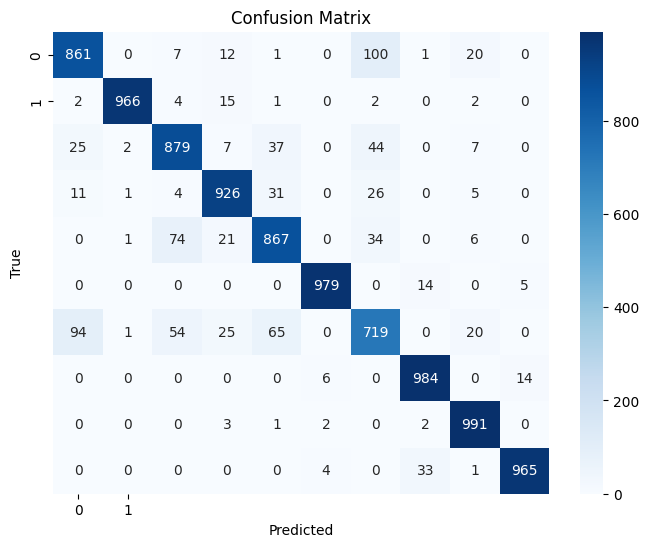

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Collect predictions and true labels
all_preds = []
all_labels = []

# Get the data stream for validation
validstreamer = valid.stream()

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for _ in range(len(valid)):  # Iterate through all validation batches
        data, target = next(validstreamer)  # Fetch a batch from the validation stream

        # Move the data and target to the GPU (cuda:0)
        data, target = data.to(device), target.to(device)

        # Forward pass through the model
        output = model(data)
        preds = output.argmax(dim=1)

        # Collect the predictions and true labels
        all_preds.extend(preds.cpu().numpy())  # Moving to CPU and converting to numpy
        all_labels.extend(target.cpu().numpy())

# Compute the confusion matrix using sklearn
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
